## Animation Generation Example

In [26]:
try:
    import platipy
except:
    !pip install git+https://github.com/pyplati/platipy.git
    import platipy

import pathlib

import SimpleITK as sitk
import numpy as np

from platipy.imaging.registration.utils import apply_transform

from platipy.imaging.visualisation.visualiser import ImageVisualiser
from platipy.imaging.visualisation.utils import project_onto_arbitrary_plane
from platipy.imaging.visualisation.animation import generate_animation_from_image_sequence

from platipy.imaging.utils.crop import label_to_roi
from platipy.imaging.label.utils import get_com

from platipy.imaging.tests.data import get_lung_nifti

"""
Deformation field operations
"""
from platipy.imaging.generation.mask import (
get_bone_mask,
get_external_mask)

from platipy.imaging.generation.dvf import (
generate_field_shift,
generate_field_asymmetric_contract,
generate_field_asymmetric_extend,
generate_field_expand,
generate_field_radial_bend
)

%matplotlib inline

## Load data

Read in some images and structures for this demonstration
We are using a lung radiotherapy dataset comprising CT and RTSTRUCT

In [12]:
nifti_data = get_lung_nifti()

image_ct = sitk.ReadImage(str(nifti_data.joinpath("LCTSC-Test-S1-101/IMAGES/LCTSC_TEST_S1_101_0_CT_0.nii.gz")))

structure_list = ["HEART", "ESOPHAGUS", "LUNG_L", "LUNG_R", "SPINALCORD"]
label_images = {i:sitk.ReadImage(str(nifti_data.joinpath(f"LCTSC-Test-S1-101/STRUCTURES/LCTSC_TEST_S1_101_0_RTSTRUCT_{i}.nii.gz"))) for i in structure_list}

## Get the an external mask and generate a radial bend

In [13]:
external_mask = get_external_mask(image_ct, dilate=5)

label_expand, expand_transform, expand_dvf = generate_field_radial_bend(
    image_ct,
    external_mask,
    reference_point=get_com(label_images["HEART"]),
    axis_of_rotation=[0,0,1],
    scale=0.5
)

## Interpolate at different positions for the animation

In [25]:
interp_list = np.linspace(0, 1, 10)
image_list = []
scalar_list = []

for index, interp_value in enumerate(interp_list):
    
    print(index, interp_value)
    

    """
    Generate interpolated DVF
    """

    expand_dvf_interpolate = sitk.Compose(*[float(interp_value)*sitk.VectorIndexSelectionCast(expand_dvf, i, sitk.sitkFloat64) for i in [0,1,2]])
    expand_transform_interpolate = sitk.DisplacementFieldTransform( expand_dvf_interpolate )

    #print("  Interpolation complete.")

    """
    Generate deformed and projected image
    """

    im_deform = apply_transform(image_ct, transform=expand_transform_interpolate, interpolator=sitk.sitkLinear)


    im_project = project_onto_arbitrary_plane(
        im_deform,
        projection_name='mean',
        rotation_axis=[0,0,1],
        rotation_angle=0,
        projection_axis=0
    )

    image_list.append(im_project)
    

0 0.0
1 0.1111111111111111
2 0.2222222222222222
3 0.3333333333333333
4 0.4444444444444444
5 0.5555555555555556
6 0.6666666666666666
7 0.7777777777777777
8 0.8888888888888888
9 1.0


## Generate the Animation

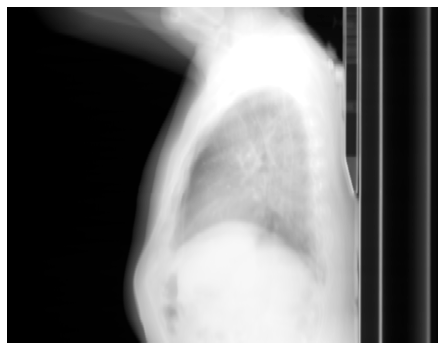

In [27]:
animation = generate_animation_from_image_sequence(image_list + image_list[::-1], "animation_twist.gif", scalar_list=None, fps=25)

In [39]:
angle_list = np.linspace(0, np.pi*2, 50)
image_list = []
contour_list = []
scalar_list = []

for angle in angle_list:
    im_rotate = project_onto_arbitrary_plane(
        image_ct,
        projection_name='mean',
        rotation_axis=[0,0,1],
        rotation_angle=angle,
        projection_axis=1
    )
    image_list.append(im_rotate)
    
    contour_rotate_lung_l = project_onto_arbitrary_plane(
        label_images["LUNG_L"],
        projection_name='max',
        rotation_axis=[0,0,1],
        rotation_angle=angle,
        projection_axis=1,
        resample_interpolation=1,
        default_value=0    
    )
    
    contour_rotate_lung_r= project_onto_arbitrary_plane(
        label_images["LUNG_R"],
        projection_name='max',
        rotation_axis=[0,0,1],
        rotation_angle=angle,
        projection_axis=1,
        resample_interpolation=1,
        default_value=0    
    )
    
    contour_list.append({"LUNG L": contour_rotate_lung_l, "LUNG R": contour_rotate_lung_r})
    
    scalar_rotate =  project_onto_arbitrary_plane(
        label_images["HEART"],
        projection_name='mean',
        rotation_axis=[0,0,1],
        rotation_angle=angle,
        projection_axis=1,
        resample_interpolation=1,
        default_value=0    
    )
    
    combined_scalar = 1*contour_rotate_lung_l + 2*contour_rotate_lung_r + 3+sitk.Cast(scalar_rotate, sitk.sitkUInt8)
    
    scalar_list.append(scalar_rotate)

No contour levels were found within the data range.
No contour levels were found within the data range.
No contour levels were found within the data range.


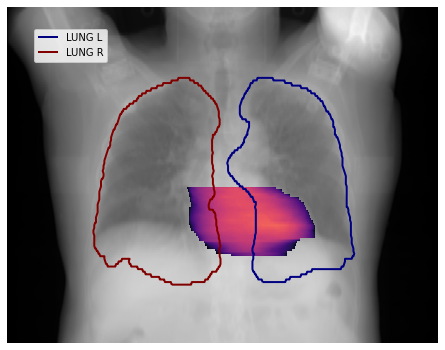

In [40]:
animation = generate_animation_from_image_sequence(image_list, contour_list=contour_list, scalar_list=scalar_list, scalar_alpha=1, scalar_min=0.01, fps=2)